# Analyzing Assessed Value of the Downtown Mall

# Step 1: Aquire Data

# Step 2: Prepare Data

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import requests
import folium
import geojson

%matplotlib inline

## Import .xls retrieved from the GIS Viewer into pandas

In [2]:
#Path to the .xls retrieve from the GIS Viewer
f = r'./data/mall_parcels_no_ends.xls'
#Create a dataframe that reads the .xls file
df = pd.read_excel(f)
#Identify all rows in df where MULTIPIN column is not equal to 1
not_multipin = df['MULTIPIN'] != 1
#Create a new dataframe that only contains the rows identified in not_multipin
df = df[not_multipin]

## Access geojson data for parcel area boundaries

In [3]:
formatted_gpins = [str(x) for x in df['GPIN'].unique()]
formatted_gpins = formatted_gpins
formatted_gpins = ','.join(formatted_gpins)

# Url for Parcel Area Boundary geojson data
parcel_url = f'https://opendata.arcgis.com/datasets/320d465ddf0d498796da6491e21f6dde_43.geojson?where=GPIN%20in%20({formatted_gpins})'

## Convert geojson parcel boundary data to dataframe

In [4]:
# Turn geojson data into dataframe
geojson_df = pd.read_json(parcel_url)
geojson_features_df = geojson_df['features']
geojson_features_df_generator = (x for x in geojson_features_df)
ft_list = []
for x in geojson_features_df_generator:
    ft_list.append([x['properties']['GPIN'],x['geometry']['coordinates']])
geojson_df = pd.DataFrame(ft_list, columns = ['GPIN','coordinates'])
ft_list = []
geojson_df['GPIN_str'] = pd.DataFrame(geojson_df['GPIN'], dtype = 'str')
geojson_df = geojson_df.drop('GPIN', axis = 1)
geojson_df['GPIN'] = pd.DataFrame(geojson_df['GPIN_str'], dtype = 'str')
geojson_df = geojson_df.drop('GPIN_str', axis = 1)

# --- Works, don't delete it --- Merge assessment data df to geojson_df
#z = temp_df.merge(geojson_df, left_on = 'GPIN', right_on = 'GPIN_str')
#z

## Access json annual assessment data

In [5]:
formatted_pins = [f'%27{x}%27' for x in df['PIN'].unique()]
formatted_pins = formatted_pins
formatted_pins = ','.join(formatted_pins)

assessment_url = f"https://gisweb.charlottesville.org/arcgis/rest/services/OpenData_2/MapServer/2/query?where=UPPER(ParcelNumber)%20in%20({formatted_pins})%20&outFields=ParcelNumber,LandValue,ImprovementValue,TotalValue,TaxYear&outSR=4326&f=json"

assessment_request = requests.get(assessment_url)

d1 = assessment_request.json()

## Convert json assessment data to dataframe

In [6]:
# Create data series based on features and combine data frames into a single df
df1 = pd.DataFrame(d1['features'])
# Create a single data frame based on combined series data
assessments = pd.DataFrame([x for x in df1['attributes']], dtype = 'object')
assessments = assessments.astype({'TaxYear': 'int64', 'ImprovementValue': 'int64','LandValue': 'int64','TotalValue': 'int64', 'ParcelNumber': 'str'})
assessments.head()

,ImprovementValue,LandValue,ParcelNumber,TaxYear,TotalValue
0,2924500,3039000,280001000,2019,5963500
1,2752000,2969100,280001000,2018,5721100
2,2826745,2969100,280001000,2017,5795845
3,1746300,2254200,280001000,2016,4000500
4,1746300,2049300,280001000,2015,3795600


## Create data frame from df that holds PIN and GPIN.

In [7]:
df_key = pd.DataFrame(df[['PIN','GPIN']], dtype = 'str')

## Merge df_key with assessments

In [8]:
d = pd.merge(assessments, df_key, how='inner', left_on=['ParcelNumber'], right_on=['PIN'])
d.head()

,ImprovementValue,LandValue,ParcelNumber,TaxYear,TotalValue,PIN,GPIN
0,2924500,3039000,280001000,2019,5963500,280001000,6861
1,2752000,2969100,280001000,2018,5721100,280001000,6861
2,2826745,2969100,280001000,2017,5795845,280001000,6861
3,1746300,2254200,280001000,2016,4000500,280001000,6861
4,1746300,2049300,280001000,2015,3795600,280001000,6861


## Merge geojson_df with d

In [9]:
geojson_assessment_df = d.merge(geojson_df, on = 'GPIN')

## Store year_min, max, and a generator of years into variables

In [10]:
#Create data frame of assessed values for all parcels by specified year
year_min = int(d['TaxYear'].min())
year_max = int(d['TaxYear'].max())
years = (x for x in range(year_min, year_max+1))

## Create a df for plotting assessments over time

In [11]:
assessment_chart_list = []
for x in years:
    year_col = x
    land_col_mean = geojson_assessment_df['LandValue'][d['TaxYear'] == x].mean()
    imp_col_mean = geojson_assessment_df['ImprovementValue'][d['TaxYear'] == x].mean()
    total_col_mean = geojson_assessment_df['TotalValue'][d['TaxYear'] == x].mean()
    
    land_col_min = geojson_assessment_df['LandValue'][d['TaxYear'] == x].min()
    imp_col_min = geojson_assessment_df['ImprovementValue'][d['TaxYear'] == x].min()
    total_col_min = geojson_assessment_df['TotalValue'][d['TaxYear'] == x].min()
    
    land_col_max = geojson_assessment_df['LandValue'][d['TaxYear'] == x].max()
    imp_col_max = geojson_assessment_df['ImprovementValue'][d['TaxYear'] == x].max()
    total_col_max = geojson_assessment_df['TotalValue'][d['TaxYear'] == x].max()
    
    assessment_chart_list.append(
        [year_col, land_col_mean, imp_col_mean, total_col_mean, land_col_min, imp_col_min, 
         total_col_min, land_col_max, imp_col_max, total_col_max])
assessment_chart_cols = ['Tax Year', 'Mean Land Value', 'Mean Improvement Value', 'Mean Total Value',
    'Min Land Value', 'Min Improvement Value', 'Min Total Value', 'Max Land Value', 'Max Improvement Value', 
    'Max Total Value']
assessment_chart_df = pd.DataFrame(assessment_chart_list, columns = assessment_chart_cols)
assessment_chart_list = []

# Step 3: Analyze

In [12]:
def all_values_by_year(year):
    all_values_df = geojson_assessment_df[geojson_assessment_df['TaxYear'] == year]
    all_values_df = all_values_df.astype({'GPIN': 'int', 'TotalValue': 'int'})
    return all_values_df

# Step 4: Report

## Plot Values over time

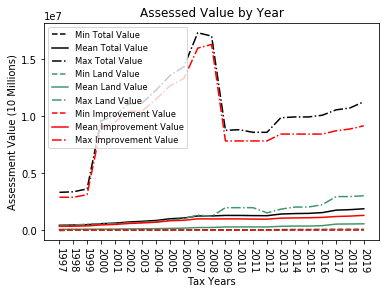

In [13]:
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Total Value'], linestyle = '--', color = '#000000', label='Min Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Total Value'], linestyle = '-', color = '#000000', label='Mean Total Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Total Value'], linestyle = '-.', color = '#000000', label='Max Total Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Land Value'], linestyle = '--', color = '#41966d',  label='Min Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Land Value'], linestyle = '-', color = '#41966d', label='Mean Land Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Land Value'],  linestyle = '-.', color = '#41966d', label='Max Land Value')

plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Min Improvement Value'], linestyle = '--', color = '#ff0000', label='Min Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Mean Improvement Value'], linestyle = '-', color = '#ff0000', label='Mean Improvement Value')
plt.plot(assessment_chart_df['Tax Year'], assessment_chart_df['Max Improvement Value'], linestyle = '-.', color = '#ff0000', label='Max Improvement Value')

plt.title('Assessed Value by Year')
plt.xlabel('Tax Years')
plt.ylabel('Assessment Value (10 Millions)')

plt.xticks(range(assessment_chart_df['Tax Year'].min(), assessment_chart_df['Tax Year'].max()+1), rotation=270)
plt.yticks(range(0, int(assessment_chart_df['Max Total Value'].max()), 5000000))

plt.legend(fontsize = 'small')
plt.savefig('plot.png', dpi=300, edgecolor = 'w', orientation='landscape')

## Map assessed value by year

In [14]:
def choropleth_assessed_val_by_year(year):
    m = folium.Map(location=[38.03090, -78.48044], zoom_start=17, tiles='OpenStreetMap')
    folium.Choropleth(
        geo_data = parcel_url,
        data=all_values_by_year(year)[['GPIN', 'TotalValue']],
        columns=['GPIN', 'TotalValue'], 
        key_on='feature.properties.GPIN', 
        bins=[0, 250000, 500000, 1000000, 2000000, 5000000, 10000000, 16000000],
        fill_color= 'YlOrRd',
        nan_fill_color='black', 
        fill_opacity=0.9, 
        nan_fill_opacity=1, 
        line_color='black', 
        line_weight=1, 
        line_opacity=1, 
        name='Assessed Value',
        legend_name= f'Total Assessed Value {year}'
    ).add_to(m)
    return(m)

choropleth_assessed_val_by_year(2019)

# Use this to create a new geojson dataset for map application

In [22]:
#https://gis.stackexchange.com/questions/220997/pandas-to-geojson-multiples-points-features-with-python
def data2geojson(df):
    features = []
    insert_features = lambda X: features.append(
            geojson.Feature(geometry=geojson.Polygon((X["coordinates"]),
                            properties=dict(name=X["GPIN"],
                            description=X["TotalValue"]))))
    df.apply(insert_features, axis=1)
    with open('map1.geojson', 'w', encoding='utf8') as fp:
        geojson.dump(geojson.FeatureCollection(features), fp, sort_keys=True, ensure_ascii=False)

data2geojson(geojson_assessment_df)

m = folium.Map(location=[38.03090, -78.48044], zoom_start=17, tiles='OpenStreetMap')
folium.GeoJson(r'./map1.geojson',name='geojson').add_to(m)
m

- Turn this dataset back into geojson data using the function from se
- Write a function that returns subset of data by year
- Create a map of assessed parcel value over time

In [17]:
geojson_assessment_df.head()

,ImprovementValue,LandValue,ParcelNumber,TaxYear,TotalValue,PIN,GPIN,coordinates
0,2924500,3039000,280001000,2019,5963500,280001000,6861,"[[[-78.48280641299056, 38.03075462954861], [-7..."
1,2752000,2969100,280001000,2018,5721100,280001000,6861,"[[[-78.48280641299056, 38.03075462954861], [-7..."
2,2826745,2969100,280001000,2017,5795845,280001000,6861,"[[[-78.48280641299056, 38.03075462954861], [-7..."
3,1746300,2254200,280001000,2016,4000500,280001000,6861,"[[[-78.48280641299056, 38.03075462954861], [-7..."
4,1746300,2049300,280001000,2015,3795600,280001000,6861,"[[[-78.48280641299056, 38.03075462954861], [-7..."
